<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/SQL2GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets networkx -q

!pip install torch_geometric -q


# Install Pytorch & other libraries
!pip install torch tensorboard --quiet

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

#FlashAttention only supports Ampere GPUs or newer. #NEED A100 , L4  IN GOOGLE COLAB
!pip install -U flash-attn --no-build-isolation --quiet


! pip install peft --quiet
! pip install datasets trl ninja packaging --quiet

# Uncomment only if you're using A100 GPU
#!pip install flash-attn --no-build-isolation
!pip install diffusers safetensors  --quiet
!pip install colab-env --quiet

!pip install mistral_inference -q

!pip install trl==0.8.6 -q


!pip install torch-geometric -q
!pip install sqlparse networkx -q

!pip install bitsandbytes -q

In [1]:
# 1. Load and Prepare Data
from datasets import load_dataset
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle(seed=42).select(range(1250))

In [2]:
import networkx as nx

G = nx.Graph()

for sample in dataset:
    table_name = sample['context'].split()[2]  # Extract table name
    G.add_node(table_name, type='table')

    columns = sample['context'].split("(", 1)[1].split(")")[0].split(",")  # Extract columns
    for col in columns:
        col_name, col_type = col.strip().split()
        G.add_node(col_name, type='column')
        G.add_edge(table_name, col_name)  # Connect table to column

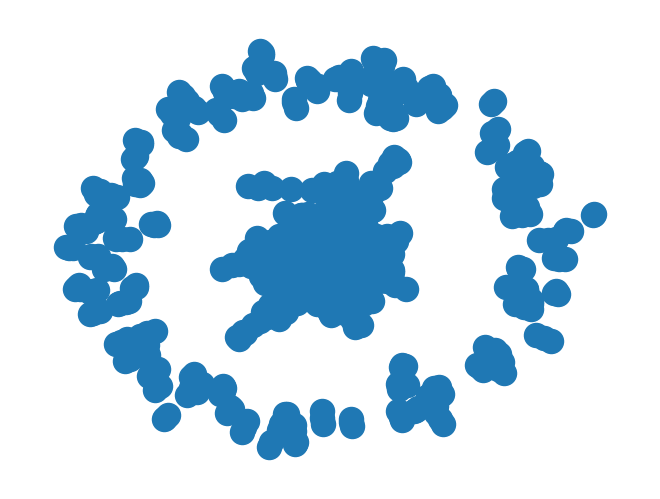

In [3]:
# Plot
nx.draw(G)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7FA9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


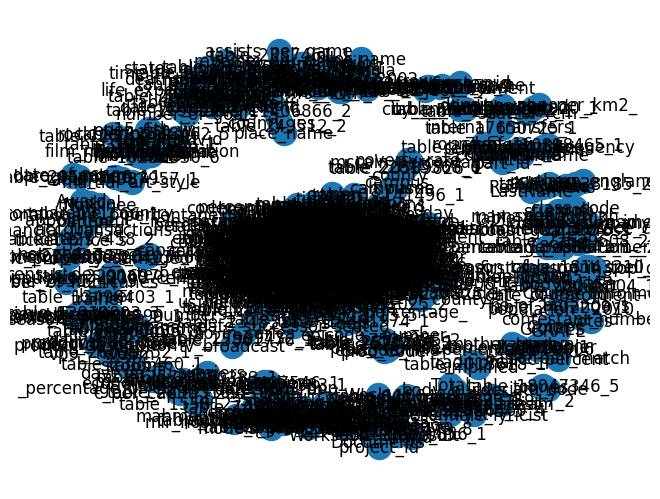

In [4]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # Choose a layout algorithm
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos)

plt.show()

In [5]:
# Number of nodes (tables + columns)
num_nodes = G.number_of_nodes()
print("Number of nodes:", num_nodes)

# Number of edges (table-column relationships)
num_edges = G.number_of_edges()
print("Number of edges:", num_edges)

# Average degree (average number of connections per node)
avg_degree = sum(dict(G.degree()).values()) / float(num_nodes)
print("Average degree:", avg_degree)

# Density (proportion of possible edges that actually exist)
density = nx.density(G)
print("Density:", density)


Number of nodes: 1622
Number of edges: 2753
Average degree: 3.3945745992601726
Density: 0.0020941237503147273


* Number of Nodes (1622): This indicates
that your database schema has a considerable number of tables and attributes (columns). It could be a large or complex schema.

* Number of Edges (2753): The number of edges signifies the total number of relationships between tables and their attributes. It suggests that the tables are fairly interconnected.

* Average Degree (3.39): This is the average number of connections per node. In this context, it implies that each table or attribute is connected to roughly 3-4 other tables or attributes on average. This further supports the idea of a well-connected schema.

* Density (0.0021): This metric indicates the proportion of possible connections that actually exist in the graph. A low density like 0.0021 suggests that while the graph is connected, it's not overly dense. There's still room for more relationships to be formed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import ModelOutput
from dataclasses import dataclass
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
import networkx as nx
from datasets import load_dataset
import numpy as np


# Load Hugging Face Dataset
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle(seed=42).select(range(1250))  # Smaller subset for demonstration

# Create Graph G
G = nx.Graph()

for sample in dataset:
    table_name = sample['context'].split()[2]
    G.add_node(table_name, type='table')
    columns = sample['context'].split("(", 1)[1].split(")")[0].split(",")
    for col in columns:
        col_name, col_type = col.strip().split()
        G.add_node(col_name, type='column')
        G.add_edge(table_name, col_name)

# Add Self-Loops to G (Ensure every node has a self-loop)
for node in G.nodes():
    G.add_edge(node, node)

# Extract Node Features from G
node_features = []
for node, data in G.nodes(data=True):
    node_type = data['type']
    node_feature = [1, 0] if node_type == 'table' else [0, 1]
    node_features.append(node_feature)
node_features = torch.tensor(node_features, dtype=torch.float)

# Extract Edge Index from G and convert to dense adjacency matrix
node_to_id = {node: i for i, node in enumerate(G.nodes())}
edge_index = torch.tensor([[node_to_id[src], node_to_id[tgt]] for src, tgt in G.edges()], dtype=torch.long)

# Handle Potential Empty Graph
if edge_index.numel() == 0:
    adj_matrix = torch.zeros((1, 1))  # Create a dummy adjacency matrix for a single isolated node
else:
    adj_matrix = to_dense_adj(edge_index)[0]

# Calculate max_nodes outside the loop
adj_matrices = [adj_matrix.numpy()]
max_nodes = max(adj.shape[0] for adj in adj_matrices)

# Load Mistral Model and Tokenizer

#tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
##config = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1").config
#config.output_hidden_states = True
#model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", config=config)
#tokenizer.pad_token = tokenizer.eos_token

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import setup_chat_format

# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.3" #24 JUNE 2024

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

config = AutoModelForCausalLM.from_pretrained(model_id).config
config.output_hidden_states = True
#model = AutoModelForCausalLM.from_pretrained(model_id, config=config)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    config=config
)

tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True)
tokenizer.padding_side = 'right' # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.unk_token_id

# # set chat template to OAI chatML, remove if you start from a fine-tuned model
model, tokenizer = setup_chat_format(model, tokenizer)

# Prepare Your Dataset (Include Tokenization and Padding)
train_dataset = []
for i, sample in enumerate(dataset):
    # Pad Adjacency Matrix
    padded_adj_matrix = np.pad(adj_matrix.numpy(), ((0, max_nodes - adj_matrix.shape[0]), (0, max_nodes - adj_matrix.shape[0])), mode='constant')

    # Tokenize input and add an extra eos_token at the end.
    encodings = tokenizer(
        sample['question'] + sample['context'] + tokenizer.eos_token,
        truncation=True, padding=True, return_tensors="pt"
    )

    # Tokenize labels, ensuring no empty sequences and padding to match the length of input_ids
    with tokenizer.as_target_tokenizer():
        label_encoding = tokenizer(
            sample['answer'],
            truncation=True,
            padding="max_length",
            max_length=len(encodings["input_ids"][0]),
            return_tensors="pt"
        )

    if len(label_encoding['input_ids'][0]) == 0:
        continue  # Skip samples with empty labels (after padding)

    # Append to the dataset
    train_dataset.append({
        'input_ids': encodings['input_ids'][0],
        'attention_mask': encodings['attention_mask'][0],
        'node_features': node_features,
        'adj_matrix': torch.tensor(padded_adj_matrix, dtype=torch.float),
        'labels': label_encoding['input_ids'][0]
    })


# Define Custom Model Output Class
@dataclass
class MistralGNNOutput(ModelOutput):
    loss: torch.FloatTensor = None
    logits: torch.FloatTensor = None
    past_key_values: torch.FloatTensor = None
    hidden_states: torch.FloatTensor = None
    attentions: torch.FloatTensor = None

# Define the Mistral Model with GNN
class MistralWithGNN(torch.nn.Module):
    def __init__(self, base_model, hidden_size):
        super().__init__()
        self.mistral = base_model
        self.hidden_size = hidden_size

        # Use bfloat16 for GCN layer to match Mistral
        self.conv1 = GCNConv(2, hidden_size)

        # Cast the weights of the convolution layer to bfloat16 after initialization
        self.conv1.lin.weight = nn.Parameter(self.conv1.lin.weight.to(torch.bfloat16))

        # Use bfloat16 for linear layers to match Mistral
        self.linear = nn.Linear(hidden_size, hidden_size, dtype=torch.bfloat16)

        # Cast the weights of graph_projection to bfloat16
        self.graph_projection = nn.Linear(hidden_size, base_model.config.hidden_size, dtype=torch.bfloat16)
        self.graph_projection.weight = nn.Parameter(self.graph_projection.weight.to(torch.bfloat16))
        if self.graph_projection.bias is not None:
            self.graph_projection.bias = nn.Parameter(self.graph_projection.bias.to(torch.bfloat16))


        # Use bfloat16 for linear layers to match Mistral
        #self.linear = nn.Linear(hidden_size, hidden_size, dtype=torch.bfloat16)
        #self.graph_projection = nn.Linear(hidden_size, base_model.config.hidden_size, dtype=torch.bfloat16)




# Attention Layers for node features (use bfloat16)
        self.node_attn_q = nn.Linear(base_model.config.hidden_size, hidden_size, dtype=torch.bfloat16)
        self.node_attn_k = nn.Linear(base_model.config.hidden_size, hidden_size, dtype=torch.bfloat16)
        self.node_attn_v = nn.Linear(base_model.config.hidden_size, hidden_size, dtype=torch.bfloat16)



        # Add this line to initialize the projection layer
        self.projection = nn.Linear(self.hidden_size, self.mistral.config.hidden_size, dtype=torch.bfloat16)



    def forward(self, input_ids, attention_mask, node_features, adj_matrix, labels=None):
        # Move tensors to the same device as the model
        device = next(self.mistral.parameters()).device  # Get the device of the Mistral model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Cast node features and adj_matrix to bfloat16
        node_features = node_features.to(torch.bfloat16)
        adj_matrix = adj_matrix.to(torch.bfloat16)

        if labels is not None:
            labels = labels.to(device)


        mistral_output = self.mistral(input_ids, attention_mask=attention_mask)
        hidden_states = mistral_output.hidden_states[-1]


        # Process graph using GCN (Handle empty graph case)
        if adj_matrix.shape[0] > 1:
            graph_output = self.conv1(node_features, adj_matrix)
            graph_output = F.relu(graph_output)
            graph_output = self.linear(graph_output)
        else:
            # Handle the single-node case by creating a zero tensor of appropriate shape
            graph_output = torch.zeros(1, self.hidden_size, device=adj_matrix.device)


        # Cast graph_output to bfloat16 before passing it to graph_projection
        graph_output = self.graph_projection(graph_output.bfloat16())  # Change here


        # Attention over the graph output to align with the input sequence length
        Q = self.node_attn_q(hidden_states)
        K = self.node_attn_k(graph_output)
        V = self.node_attn_v(graph_output)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attn_scores = attn_scores.masked_fill(attention_mask.unsqueeze(-1) == 0, float('-inf'))
        attn_weights = torch.softmax(attn_scores, dim=-1)
        contextualized_graph_output = torch.matmul(attn_weights, V)

        # Move the projection layer to the correct device
        self.projection = self.projection.to(device)

        # Project contextualized_graph_output to match hidden_states dimension
        contextualized_graph_output = self.projection(contextualized_graph_output)

        # Combine outputs
        combined_output = hidden_states + contextualized_graph_output

        # Use the combined output to predict the next token
        logits = self.mistral.lm_head(combined_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))  # Calculate the loss here
            #loss = loss


        return MistralGNNOutput(
            loss=loss,
            logits=logits,   # return logits without shifting
            past_key_values=mistral_output.past_key_values,
            hidden_states=mistral_output.hidden_states,
            attentions=mistral_output.attentions,
        )



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
# Training Arguments
training_args = TrainingArguments(
    "graph-SQL",
    logging_dir="graph-SQL",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
)

# Train the Model
trainer = Trainer(
    #model=MistralWithGNN(model, hidden_size=128),
    model=MistralWithGNN(model, hidden_size=4),
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Epoch,Training Loss,Validation Loss
